# Geotagged Only

In [2]:
!pip install epiweeks
!pip install -U kaleido

  Using cached epiweeks-2.1.4-py3-none-any.whl (5.9 kB)

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl (79.9 MB)

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import tqdm
import pandas as pd
from multiprocessing import Pool # multithreading
from epiweeks import Week

# granularity
def granularity_helper(row):
    
    s = row[1]["gmaps_address"]
    
    week = Week.fromdate(row[1]["DateTime"], system="iso")
    row[1]["epi_week"] = week.cdcformat()
    return row[1]



def granularity(df):
    
    pool = Pool(processes=round(len(df.index)/10000))

    result_arr = []
    

    for result in tqdm.tqdm(pool.imap_unordered(granularity_helper, df.iterrows()),
                            total=len(df.index)):
        result_arr.append(result)
    

    df = pd.concat(result_arr, axis=1).transpose().sort_index()

                
    return df

In [4]:
################ GEOTAGGED ONLY ##########################

# get distances column from all datasets
# first determine if there are any duplicate tweet ids in there

import pandas as pd
import tqdm

for i in range(91, 112):
    print("starting ", i)
    df = pd.read_feather("s3://mt5599/final/processed_tweets_" + str(i) + ".feather")

    # keep tweets with no distances and NER mention
    df = df[pd.notnull(df.place_full_name)]
    df = granularity(df)
    df = df.reset_index()
    df.to_feather("s3://mt5599/dissertation/geotagged_" + str(i) + ".feather" )



starting  91


100%|██████████| 461013/461013 [02:57<00:00, 2599.26it/s]


starting  92


100%|██████████| 473844/473844 [03:00<00:00, 2627.92it/s]


starting  93


100%|██████████| 448392/448392 [02:56<00:00, 2535.67it/s]


starting  94


100%|██████████| 426705/426705 [02:38<00:00, 2685.62it/s]


starting  95


100%|██████████| 442166/442166 [02:55<00:00, 2522.49it/s]


starting  96


100%|██████████| 487806/487806 [03:15<00:00, 2491.92it/s]


starting  97


100%|██████████| 504368/504368 [03:13<00:00, 2605.96it/s]


starting  98


100%|██████████| 469258/469258 [03:08<00:00, 2487.74it/s]


starting  99


100%|██████████| 430003/430003 [02:46<00:00, 2586.85it/s]


starting  100


100%|██████████| 401253/401253 [02:40<00:00, 2501.40it/s]


starting  101


100%|██████████| 413354/413354 [02:48<00:00, 2452.68it/s]


starting  102


100%|██████████| 520385/520385 [03:32<00:00, 2445.97it/s]


starting  103


100%|██████████| 427426/427426 [02:56<00:00, 2427.04it/s]


starting  104


100%|██████████| 419649/419649 [02:53<00:00, 2422.12it/s]


starting  105


100%|██████████| 376360/376360 [02:37<00:00, 2396.50it/s]


starting  106


100%|██████████| 451433/451433 [03:03<00:00, 2459.13it/s]


starting  107


100%|██████████| 427368/427368 [02:59<00:00, 2374.59it/s]


starting  108


100%|██████████| 380312/380312 [02:42<00:00, 2344.21it/s]


starting  109


100%|██████████| 393183/393183 [02:44<00:00, 2389.75it/s]


starting  110


100%|██████████| 384443/384443 [02:44<00:00, 2340.73it/s]


starting  111


100%|██████████| 362741/362741 [02:37<00:00, 2309.85it/s]


In [5]:
# combining into one dataset

import tqdm
import pandas as pd

dfs = []

for i in tqdm.tqdm(range(0, 112)):
    df = pd.read_feather("s3://mt5599/dissertation/geotagged_" + str(i) + ".feather")

    dfs.append(df)

df = pd.concat(dfs, axis=0, ignore_index=True).reset_index(drop=True).reset_index()
df.to_feather("s3://mt5599/final/geotagged.feather")


100%|██████████| 112/112 [08:15<00:00,  4.42s/it]


In [1]:
import pandas as pd

df = pd.read_feather("s3://mt5599/final/geotagged.feather")
print("read")
df = df.drop_duplicates("id").drop(["level_0", "index"], axis=1)
print("cleaning")
df

read
cleaning


,id,DateTime,coordinates,place,username,user_id,user_location,tweet_content,lang,tweet_clean,...,place_country_code,coordinates_longitude,coordinates_latitude,ner_type,ner_word,gmaps_lat,gmaps_long,gmaps_address,distance,epi_week
0,676710697422725120,2015-12-15 10:29:37+00:00,"Coordinates(longitude=-57.5592828, latitude=-3...","Place(fullName='Mar del Plata, Argentina', nam...",darcena2553,2358639522,No soy unica soy diferente,A rendir,es,A rendir,...,AR,-57.559283,-38.058940,None,None,NaN,NaN,None,NaN,201551
1,674648800020033536,2015-12-09 17:56:22+00:00,"Coordinates(longitude=-57.5548276, latitude=-3...","Place(fullName='Mar del Plata, Argentina', nam...",darcena2553,2358639522,No soy unica soy diferente,¿Que paso?,es,Que paso?,...,AR,-57.554828,-38.059752,None,None,NaN,NaN,None,NaN,201550
2,671493815635746816,2015-12-01 00:59:36+00:00,"Coordinates(longitude=-57.5548158, latitude=-3...","Place(fullName='Mar del Plata, Argentina', nam...",darcena2553,2358639522,No soy unica soy diferente,Tu cuerpo me hace babear inundando el colegio ...,es,Tu cuerpo me hace babear inundando el colegio ...,...,AR,-57.554816,-38.059739,None,None,NaN,NaN,None,NaN,201549
3,669967909456879616,2015-11-26 19:56:11+00:00,"Coordinates(longitude=-57.5591638, latitude=-3...","Place(fullName='Mar del Plata, Argentina', nam...",darcena2553,2358639522,No soy unica soy diferente,"Vieja del orto ,ojala que se muera y se PUDRA ...",es,"Vieja del orto ,ojala que se muera y se PUDRA ...",...,AR,-57.559164,-38.058979,None,None,NaN,NaN,None,NaN,201548
4,668096786893021184,2015-11-21 16:01:01+00:00,"Coordinates(longitude=-57.5548388, latitude=-3...","Place(fullName='Mar del Plata, Argentina', nam...",darcena2553,2358639522,No soy unica soy diferente,"Me miras yo te miro ,me sonrreis y me matas ,m...",es,"Me miras yo te miro ,me sonrreis y me matas ,m...",...,AR,-57.554839,-38.059755,None,None,NaN,NaN,None,NaN,201547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61395063,725087645500624896,2016-04-26 22:22:20+00:00,"Coordinates(longitude=-56.7153342, latitude=-3...","Place(fullName='San Clemente del Tuyú, Argenti...",ludmi526,3224699505,"La Costa, Argentina",Un tal Martes💫 @ bellasartessanclemente https:...,it,Un tal Martes @ bellasartessanclemente,...,AR,-56.715334,-36.378340,PER,Martes,NaN,NaN,None,NaN,201617
61395064,724364680278491136,2016-04-24 22:29:32+00:00,"Coordinates(longitude=-56.68988962, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Una de anoche. @ Santa Teresita La Costa https...,es,Una de anoche. @ Santa Teresita La Costa,...,AR,-56.689890,-36.538927,LOC,Santa Teresita La Costa,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.570435,201616
61395065,724358546779983872,2016-04-24 22:05:10+00:00,"Coordinates(longitude=-56.68988962, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",I need you. @ Santa Teresita La Costa https://...,it,I need you. @ Santa Teresita La Costa,...,AR,-56.689890,-36.538927,LOC,Santa Teresita La Costa,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.570435,201616
61395066,723655990579724288,2016-04-22 23:33:27+00:00,"Coordinates(longitude=-56.7153342, latitude=-3...","Place(fullName='San Clemente del Tuyú, Argenti...",ludmi526,3224699505,"La Costa, Argentina",!!!! @ bellasartessanclemente https://t.co/x2E...,it,!!!! @ bellasartessanclemente,...,AR,-56.715334,-36.378340,None,None,NaN,NaN,None,NaN,201616


In [3]:
# Investigating top 20 most geotagged countries and their frequencies

loc_vc = df.place_country.value_counts().rename_axis('unique_values').reset_index(name='counts')
loc_total = sum(loc_vc.counts)
#df_only = df[df.ner_type != "LOC"]
#only_loc_vc = df_only.place_country.value_counts().rename_axis('unique_values').reset_index(name='counts')
#only_loc_total = sum(loc_only_vc.counts)

vc = pd.DataFrame(data = {"loc": [],
                          "loc_counts": [],
                          "loc_prop": []})
                    #     "only_loc": [],
                   #      "only_loc_counts": [],
                   #      "only_loc_prop": []})

n = 20
for i in range(n):
    vc.loc[i, "loc"] = loc_vc.loc[i, "unique_values"]
    vc.loc[i, "loc_counts"] = loc_vc.loc[i, "counts"]
    vc.loc[i, "loc_prop"] = loc_vc.loc[i, "counts"] / loc_total
    
  #  vc.loc[i, "only_loc"] = only_loc_vc.loc[i, "unique_values"]
  #  vc.loc[i, "only_loc_counts"] = only_loc_vc.loc[i, "counts"]
  #  vc.loc[i, "only_loc_prop"] = only_loc_vc.loc[i, "counts"] / only_loc_total
    
vc.loc[n+1, "loc"] = "Other"
vc.loc[n+1, "loc_counts"] = loc_total - sum(loc_vc.loc[0:n, "counts"])
vc.loc[n+1, "loc_prop"] = vc.loc[n+1, "loc_counts"] / loc_total
#vc.loc[n+1, "only_loc"] = "Other"
#vc.loc[n+1, "only_loc_counts"] = only_loc_total - sum(only_loc_vc.loc[0:n, "counts"])
#vc.loc[n+1, "only_loc_prop"] = vc.loc[n+1, "only_loc_counts"] / only_loc_total

vc.reset_index(inplace=True, drop=True)
#vc.drop(0, axis=0, inplace=True)
print("Table \ref{tab:geotagged-locations} shows the number of top 20 most geotagged countries,",
      "with 'Other' denoting other countries (does not include un-geotagged tweets).")
vc

ef{tab:geotagged-locations} shows the number of top 20 most geotagged countries, with 'Other' denoting other countries (does not include un-geotagged tweets).


,loc,loc_counts,loc_prop
0,Argentina,55743738.0,0.987525
1,United States,152911.0,0.002709
2,Brazil,128727.0,0.002280
3,Chile,68889.0,0.001220
4,Uruguay,55464.0,0.000983
5,Spain,36813.0,0.000652
6,Mexico,30013.0,0.000532
7,Paraguay,29848.0,0.000529
8,Colombia,18635.0,0.000330
9,Italy,15074.0,0.000267


In [39]:
print("For each user, the countries they geotagged over the course of the relevant time period were found.")

import itertools
import numpy as np

user_df = df.groupby(['username'])["place_country"].unique().reset_index(name='countries')

# number of countries per user
countries_per_user = user_df.countries.str.len()

print()
print("The mean number of geotagged countries was ", np.mean(countries_per_user),
     "and the median was ", np.median(countries_per_user))

user_countries = user_df.countries.tolist()
all_countries = pd.DataFrame({"country":list(itertools.chain.from_iterable(user_countries))})
temp = pd.DataFrame(all_countries.country.value_counts())
common_countries = temp

print("Table \ref{tab:geotagged-locations-users} shows their breakdown.")
temp

For each user, the countries they geotagged over the course of the relevant time period were found.

The mean number of geotagged countries was  1.3829887270651189 and the median was  1.0
ef{tab:geotagged-locations-users} shows their breakdown.


,country
Argentina,89329
Brazil,6008
United States,5410
Chile,2970
Uruguay,2113
...,...
Eritrea,1
Liechtenstein,1
Djibouti,1
Equatorial Guinea,1


In [41]:
temp = temp.reset_index().rename({"index":"country", "country":"counts"},axis=1)
total_loc = temp.counts.sum()
temp["prop"] = temp["counts"]/total_loc

n = 20

temp_keep = temp[0:n]
discarded = temp[n:temp.shape[0]]

temp_keep.loc[n, "country"] = "Other"
temp_keep.loc[n, "counts"] = discarded.counts.sum()
temp_keep.loc[n, "prop"] = temp_keep.loc[n, "counts"] / total_loc

temp = temp_keep
#common_countries = temp

#print("Table \ref{tab:geotagged-locations-users} shows their breakdown.")
temp

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,country,counts,prop
0,Argentina,89329.0,0.723072
1,Brazil,6008.0,0.048632
2,United States,5410.0,0.043791
3,Chile,2970.0,0.024041
4,Uruguay,2113.0,0.017104
5,Mexico,1693.0,0.013704
6,Spain,1681.0,0.013607
7,Italy,1017.0,0.008232
8,Peru,959.0,0.007763
9,United Kingdom,939.0,0.007601


In [5]:
# ARGENTINA - tweets

ar = df[df.place_country_code == "AR"]

loc_vc = ar.place_name.value_counts().rename_axis('unique_values').reset_index(name='counts')
loc_total = sum(loc_vc.counts)
#df_only = df[df.ner_type != "LOC"]
#only_loc_vc = df_only.place_country.value_counts().rename_axis('unique_values').reset_index(name='counts')
#only_loc_total = sum(loc_only_vc.counts)

vc = pd.DataFrame(data = {"loc": [],
                          "loc_counts": [],
                          "loc_prop": []})
                    #     "only_loc": [],
                   #      "only_loc_counts": [],
                   #      "only_loc_prop": []})

n = 20
for i in range(n):
    vc.loc[i, "loc"] = loc_vc.loc[i, "unique_values"]
    vc.loc[i, "loc_counts"] = loc_vc.loc[i, "counts"]
    vc.loc[i, "loc_prop"] = loc_vc.loc[i, "counts"] / loc_total
    
  #  vc.loc[i, "only_loc"] = only_loc_vc.loc[i, "unique_values"]
  #  vc.loc[i, "only_loc_counts"] = only_loc_vc.loc[i, "counts"]
  #  vc.loc[i, "only_loc_prop"] = only_loc_vc.loc[i, "counts"] / only_loc_total
    
vc.loc[n+1, "loc"] = "Other"
vc.loc[n+1, "loc_counts"] = loc_total - sum(loc_vc.loc[0:n, "counts"])
vc.loc[n+1, "loc_prop"] = vc.loc[n+1, "loc_counts"] / loc_total
#vc.loc[n+1, "only_loc"] = "Other"
#vc.loc[n+1, "only_loc_counts"] = only_loc_total - sum(only_loc_vc.loc[0:n, "counts"])
#vc.loc[n+1, "only_loc_prop"] = vc.loc[n+1, "only_loc_counts"] / only_loc_total

vc.reset_index(inplace=True, drop=True)
#vc.drop(0, axis=0, inplace=True)
print("Table \ref{tab:geotagged-locations} shows the number of top 20 most geotagged locations within Argentina,",
      "with 'Other' denoting other countries (does not include un-geotagged tweets).")
vc

ef{tab:geotagged-locations} shows the number of top 20 most geotagged locations within Argentina, with 'Other' denoting other countries (does not include un-geotagged tweets).


,loc,loc_counts,loc_prop
0,Ciudad Autónoma de Buenos Aires,6013615.0,0.107880
1,Córdoba,4963649.0,0.089044
2,Buenos Aires,3530325.0,0.063331
3,La Plata,1824224.0,0.032725
4,Rosario,1787751.0,0.032071
5,Santa Fe,1258011.0,0.022568
6,Mar del Plata,1136730.0,0.020392
7,Entre Ríos,1108310.0,0.019882
8,Corrientes,1076449.0,0.019311
9,Neuquén,913416.0,0.016386


In [6]:
# UNITED STATES - tweets

us = df[df.place_country_code == "US"]

loc_vc = us.place_name.value_counts().rename_axis('unique_values').reset_index(name='counts')
loc_total = sum(loc_vc.counts)
#df_only = df[df.ner_type != "LOC"]
#only_loc_vc = df_only.place_country.value_counts().rename_axis('unique_values').reset_index(name='counts')
#only_loc_total = sum(loc_only_vc.counts)

vc = pd.DataFrame(data = {"loc": [],
                          "loc_counts": [],
                          "loc_prop": []})
                    #     "only_loc": [],
                   #      "only_loc_counts": [],
                   #      "only_loc_prop": []})

n = 20
for i in range(n):
    vc.loc[i, "loc"] = loc_vc.loc[i, "unique_values"]
    vc.loc[i, "loc_counts"] = loc_vc.loc[i, "counts"]
    vc.loc[i, "loc_prop"] = loc_vc.loc[i, "counts"] / loc_total
    
  #  vc.loc[i, "only_loc"] = only_loc_vc.loc[i, "unique_values"]
  #  vc.loc[i, "only_loc_counts"] = only_loc_vc.loc[i, "counts"]
  #  vc.loc[i, "only_loc_prop"] = only_loc_vc.loc[i, "counts"] / only_loc_total
    
vc.loc[n+1, "loc"] = "Other"
vc.loc[n+1, "loc_counts"] = loc_total - sum(loc_vc.loc[0:n, "counts"])
vc.loc[n+1, "loc_prop"] = vc.loc[n+1, "loc_counts"] / loc_total
#vc.loc[n+1, "only_loc"] = "Other"
#vc.loc[n+1, "only_loc_counts"] = only_loc_total - sum(only_loc_vc.loc[0:n, "counts"])
#vc.loc[n+1, "only_loc_prop"] = vc.loc[n+1, "only_loc_counts"] / only_loc_total

vc.reset_index(inplace=True, drop=True)
#vc.drop(0, axis=0, inplace=True)
print("Table \ref{tab:geotagged-locations} shows the number of top 20 most geotagged locations within Argentina,",
      "with 'Other' denoting other countries (does not include un-geotagged tweets).")
vc

ef{tab:geotagged-locations} shows the number of top 20 most geotagged locations within Argentina, with 'Other' denoting other countries (does not include un-geotagged tweets).


,loc,loc_counts,loc_prop
0,Manhattan,13989.0,0.091516
1,United States,13751.0,0.089959
2,New York,11383.0,0.074468
3,Florida,10991.0,0.071903
4,Alaska,9713.0,0.063543
5,Miami Beach,9235.0,0.060416
6,California,7967.0,0.052120
7,Miami,4486.0,0.029347
8,Buenos Aires,3165.0,0.020705
9,North Carolina,3124.0,0.020437


In [7]:
# BRAZIL - tweets

br = df[df.place_country_code == "BR"]

loc_vc = br.place_name.value_counts().rename_axis('unique_values').reset_index(name='counts')
loc_total = sum(loc_vc.counts)
#df_only = df[df.ner_type != "LOC"]
#only_loc_vc = df_only.place_country.value_counts().rename_axis('unique_values').reset_index(name='counts')
#only_loc_total = sum(loc_only_vc.counts)

vc = pd.DataFrame(data = {"loc": [],
                          "loc_counts": [],
                          "loc_prop": []})
                    #     "only_loc": [],
                   #      "only_loc_counts": [],
                   #      "only_loc_prop": []})

n = 20
for i in range(n):
    vc.loc[i, "loc"] = loc_vc.loc[i, "unique_values"]
    vc.loc[i, "loc_counts"] = loc_vc.loc[i, "counts"]
    vc.loc[i, "loc_prop"] = loc_vc.loc[i, "counts"] / loc_total
    
  #  vc.loc[i, "only_loc"] = only_loc_vc.loc[i, "unique_values"]
  #  vc.loc[i, "only_loc_counts"] = only_loc_vc.loc[i, "counts"]
  #  vc.loc[i, "only_loc_prop"] = only_loc_vc.loc[i, "counts"] / only_loc_total
    
vc.loc[n+1, "loc"] = "Other"
vc.loc[n+1, "loc_counts"] = loc_total - sum(loc_vc.loc[0:n, "counts"])
vc.loc[n+1, "loc_prop"] = vc.loc[n+1, "loc_counts"] / loc_total
#vc.loc[n+1, "only_loc"] = "Other"
#vc.loc[n+1, "only_loc_counts"] = only_loc_total - sum(only_loc_vc.loc[0:n, "counts"])
#vc.loc[n+1, "only_loc_prop"] = vc.loc[n+1, "only_loc_counts"] / only_loc_total

vc.reset_index(inplace=True, drop=True)
#vc.drop(0, axis=0, inplace=True)
print("Table \ref{tab:geotagged-locations} shows the number of top 20 most geotagged locations within Argentina,",
      "with 'Other' denoting other countries (does not include un-geotagged tweets).")
vc

ef{tab:geotagged-locations} shows the number of top 20 most geotagged locations within Argentina, with 'Other' denoting other countries (does not include un-geotagged tweets).


,loc,loc_counts,loc_prop
0,Florianópolis,23620.0,0.183489
1,Rio de Janeiro,17070.0,0.132606
2,Bombinhas,12285.0,0.095435
3,Ananindeua,8702.0,0.067600
4,Balneário Camboriú,5449.0,0.042330
5,Sao Paulo,5069.0,0.039378
6,Foz do Iguaçu,4787.0,0.037187
7,Itapema,4393.0,0.034126
8,Armação dos Búzios,2785.0,0.021635
9,Ipanema,2399.0,0.018636


In [42]:
# ARGENTINA GEOTAGS - by user

ar = df[df.place_country_code == "AR"]

import itertools

user_ar = ar.groupby(['username'])["place_name"].unique().reset_index(name='countries')

# number of countries per user
countries_per_user = user_ar.countries.str.len()

#print()
#print("The mean number of geotagged placenames in Argentina was ", np.mean(countries_per_user),
#     "and the median was ", np.median(countries_per_user))

user_countries = user_ar.countries.tolist()
all_countries = pd.DataFrame({"country":list(itertools.chain.from_iterable(user_countries))})
temp = pd.DataFrame(all_countries.country.value_counts())

print("Table \ref{tab:geotagged-locations-users} shows the breakdown of top 20 most common geotags",
      "within Argentina aggregated by user to avoid the problem of varying tweeting frequencies.")
temp

ef{tab:geotagged-locations-users} shows the breakdown of top 20 most common geotags within Argentina aggregated by user to avoid the problem of varying tweeting frequencies.


,country
Ciudad Autónoma de Buenos Aires,40660
Buenos Aires,31355
Córdoba,18180
Villa Soldati,9549
Santa Fe,9251
...,...
Los Lagos,9
Burruyacú,7
El Manzano,6
Villa Los Álamos,4


In [43]:
temp = temp.reset_index().rename({"index":"place", "country":"counts"},axis=1)
total_loc = temp.counts.sum()
temp["prop"] = temp["counts"]/total_loc

n = 20

temp_keep = temp[0:n]
discarded = temp[n:temp.shape[0]]

temp_keep.loc[n, "place"] = "Other"
temp_keep.loc[n, "counts"] = discarded.counts.sum()
temp_keep.loc[n, "prop"] = temp_keep.loc[n, "counts"] / total_loc

temp = temp_keep
#common_countries = temp

#print("Table \ref{tab:geotagged-locations-users} shows their breakdown.")
temp

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,place,counts,prop
0,Ciudad Autónoma de Buenos Aires,40660.0,0.093223
1,Buenos Aires,31355.0,0.071889
2,Córdoba,18180.0,0.041682
3,Villa Soldati,9549.0,0.021893
4,Santa Fe,9251.0,0.021210
5,La Plata,9196.0,0.021084
6,Rosario,8842.0,0.020272
7,Mar del Plata,7868.0,0.018039
8,Entre Ríos,7867.0,0.018037
9,San Isidro,7216.0,0.016544


In [44]:
print("There were a total of ", ar.shape[0]," geotagged tweets from Argentina.")

There were a total of  55743738  geotagged tweets from Argentina.


In [49]:
# UNITED STATES GEOTAGS - by user

us = df[df.place_country_code == "US"]

import itertools

user_ar = us.groupby(['username'])["place_name"].unique().reset_index(name='countries')

# number of countries per user
countries_per_user = user_ar.countries.str.len()

#print()
#print("The mean number of geotagged placenames in Argentina was ", np.mean(countries_per_user),
#     "and the median was ", np.median(countries_per_user))

user_countries = user_ar.countries.tolist()
all_countries = pd.DataFrame({"country":list(itertools.chain.from_iterable(user_countries))})
temp = pd.DataFrame(all_countries.country.value_counts())

print("Table \ref{tab:geotagged-locations-users} shows the breakdown of top 20 most common geotags",
      "within Argentina aggregated by user to avoid the problem of varying tweeting frequencies.")
temp

ef{tab:geotagged-locations-users} shows the breakdown of top 20 most common geotags within Argentina aggregated by user to avoid the problem of varying tweeting frequencies.


,country
Florida,1294
Miami Beach,1226
Manhattan,1040
Miami,946
Orlando,709
...,...
Rayo,1
Boca Velázquez,1
March Air Reserve Base,1
Almácigo Alto,1


In [46]:
temp = temp.reset_index().rename({"index":"place", "country":"counts"},axis=1)
total_loc = temp.counts.sum()
temp["prop"] = temp["counts"]/total_loc

n = 20

temp_keep = temp[0:n]
discarded = temp[n:temp.shape[0]]

temp_keep.loc[n, "place"] = "Other"
temp_keep.loc[n, "counts"] = discarded.counts.sum()
temp_keep.loc[n, "prop"] = temp_keep.loc[n, "counts"] / total_loc

temp = temp_keep
#common_countries = temp

#print("Table \ref{tab:geotagged-locations-users} shows their breakdown.")
temp

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,place,counts,prop
0,Florida,1294.0,0.076855
1,Miami Beach,1226.0,0.072816
2,Manhattan,1040.0,0.061769
3,Miami,946.0,0.056186
4,Orlando,709.0,0.042110
5,New York,417.0,0.024767
6,Los Angeles,389.0,0.023104
7,United States,350.0,0.020788
8,Brooklyn,257.0,0.015264
9,Queens,227.0,0.013482


In [47]:
# BRAZIL GEOTAGS - by user

br = df[df.place_country_code == "BR"]

import itertools

user_ar = br.groupby(['username'])["place_name"].unique().reset_index(name='countries')

# number of countries per user
countries_per_user = user_ar.countries.str.len()

#print()
#print("The mean number of geotagged placenames in Argentina was ", np.mean(countries_per_user),
#     "and the median was ", np.median(countries_per_user))

user_countries = user_ar.countries.tolist()
all_countries = pd.DataFrame({"country":list(itertools.chain.from_iterable(user_countries))})
temp = pd.DataFrame(all_countries.country.value_counts())

print("Table \ref{tab:geotagged-locations-users} shows the breakdown of top 20 most common geotags",
      "within Argentina aggregated by user to avoid the problem of varying tweeting frequencies.")
temp

ef{tab:geotagged-locations-users} shows the breakdown of top 20 most common geotags within Argentina aggregated by user to avoid the problem of varying tweeting frequencies.


,country
Florianópolis,1140
Rio de Janeiro,1032
Foz do Iguaçu,701
Bombinhas,627
Balneário Camboriú,464
...,...
Pousada Borekoko,1
Hotel Canzi,1
Balneário Arroio do Silva,1
Palotina,1


In [48]:
temp = temp.reset_index().rename({"index":"place", "country":"counts"},axis=1)
total_loc = temp.counts.sum()
temp["prop"] = temp["counts"]/total_loc

n = 20

temp_keep = temp[0:n]
discarded = temp[n:temp.shape[0]]

temp_keep.loc[n, "place"] = "Other"
temp_keep.loc[n, "counts"] = discarded.counts.sum()
temp_keep.loc[n, "prop"] = temp_keep.loc[n, "counts"] / total_loc

temp = temp_keep
#common_countries = temp

#print("Table \ref{tab:geotagged-locations-users} shows their breakdown.")
temp

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,place,counts,prop
0,Florianópolis,1140.0,0.096178
1,Rio de Janeiro,1032.0,0.087067
2,Foz do Iguaçu,701.0,0.059141
3,Bombinhas,627.0,0.052898
4,Balneário Camboriú,464.0,0.039146
5,Sao Paulo,383.0,0.032312
6,Armação dos Búzios,296.0,0.024973
7,Guarulhos,285.0,0.024045
8,Itapema,283.0,0.023876
9,Santa Catarina,166.0,0.014005


## Epi Weeks

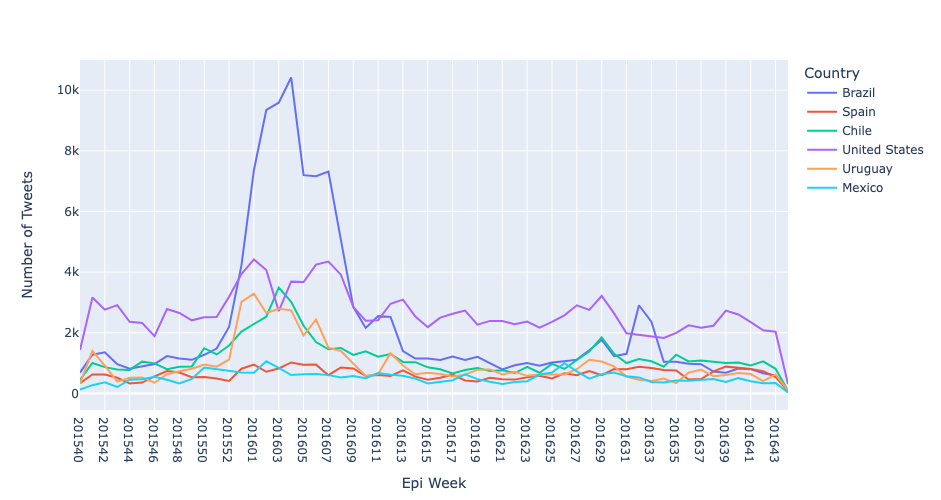

In [62]:
# Countries over Epi Weeks - tweets - no Argentina

from itertools import product
import matplotlib.pyplot as plt

top_20 = common_countries.reset_index().rename({"country":"counts",
                                                "index":"country"},axis=1).loc[0:6,"country"].tolist()
#df.place_country.value_counts().rename_axis('unique_values').reset_index(name='counts')
#top_20 = top_20.loc[,0:20]
#top_20 = top_20.loc[0:20, "unique_values"].tolist()
#top_20

import plotly.express as px

loc_p = df[(df.place_country.isin(top_20)) & (df.place_country != "Argentina")]
loc_p = loc_p.groupby(['place_country', "epi_week"])["id"].count().reset_index(name='counts')
loc_p = loc_p.sort_values(["epi_week"], ascending=True).reset_index(drop=True)

loc_temp = pd.DataFrame(list(product(loc_p.place_country.unique(), loc_p.epi_week.unique())), columns=['place_country', 'epi_week'])
loc_temp["counts"] = 0

loc_p = pd.concat([loc_p, loc_temp]).drop_duplicates(["place_country", "epi_week"])#, ignore_index=True)
loc_p = loc_p.sort_values(["epi_week"], ascending=True)

#only_loc_p = df_loc[df_loc.place_country.isin(top_20)]
#only_loc_p = only_loc_p.groupby(['place_country', "epi_week"])["id"].count().reset_index(name='counts')
# plot pie chart

fig = px.line(loc_p, x="epi_week", y="counts", color="place_country",
                 labels={
                     "epi_week": "Epi Week",
                     "counts": "Number of Tweets",
                     "place_country": "Country"},
             width=800,
             height=500)

fig.write_image("geotagged_tweets_country_epi_week.png")
fig.write_html("html/geotagged_tweets_country_epi_week.html")
fig.show()

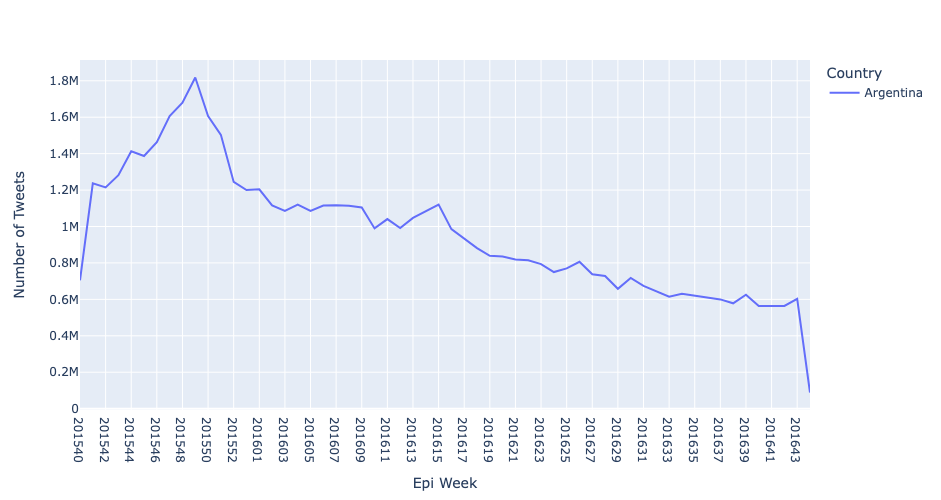

In [63]:
# Argentina over Epi Weeks - tweets

from itertools import product
import matplotlib.pyplot as plt

#top_20 = common_countries.reset_index().rename({"country":"counts",
#                                                "index":"country"},axis=1).loc[0:6,"country"].tolist()
#df.place_country.value_counts().rename_axis('unique_values').reset_index(name='counts')
#top_20 = top_20.loc[,0:20]
#top_20 = top_20.loc[0:20, "unique_values"].tolist()
#top_20

import plotly.express as px

loc_p = df[((df.place_country == "Argentina"))]
loc_p = loc_p.groupby(['place_country', "epi_week"])["id"].count().reset_index(name='counts')
loc_p = loc_p.sort_values(["epi_week"], ascending=True).reset_index(drop=True)

loc_temp = pd.DataFrame(list(product(loc_p.place_country.unique(), loc_p.epi_week.unique())), columns=['place_country', 'epi_week'])
loc_temp["counts"] = 0

loc_p = pd.concat([loc_p, loc_temp]).drop_duplicates(["place_country", "epi_week"])#, ignore_index=True)
loc_p = loc_p.sort_values(["epi_week"], ascending=True)

#only_loc_p = df_loc[df_loc.place_country.isin(top_20)]
#only_loc_p = only_loc_p.groupby(['place_country', "epi_week"])["id"].count().reset_index(name='counts')
# plot pie chart

fig = px.line(loc_p, x="epi_week", y="counts", color="place_country",
                 labels={
                     "epi_week": "Epi Week",
                     "counts": "Number of Tweets",
                     "place_country": "Country"},
             width=800,
             height=500)

fig.write_image("geotagged_tweets_argentina_epi_week.png")
fig.write_html("html/geotagged_tweets_argentina_epi_week.html")
fig.show()


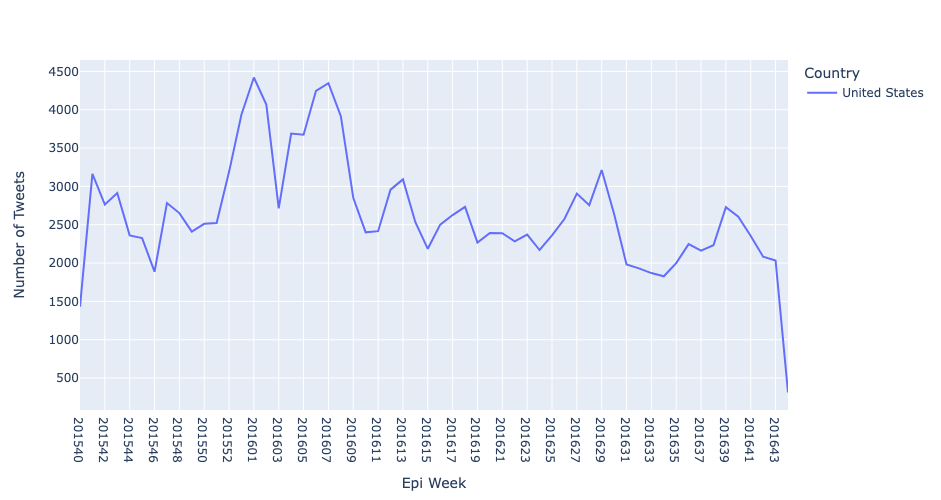

In [64]:
# USA over Epi Weeks - tweets

from itertools import product
import matplotlib.pyplot as plt

#top_20 = common_countries.reset_index().rename({"country":"counts",
#                                                "index":"country"},axis=1).loc[0:6,"country"].tolist()
#df.place_country.value_counts().rename_axis('unique_values').reset_index(name='counts')
#top_20 = top_20.loc[,0:20]
#top_20 = top_20.loc[0:20, "unique_values"].tolist()
#top_20

import plotly.express as px

loc_p = df[((df.place_country == "United States"))]
loc_p = loc_p.groupby(['place_country', "epi_week"])["id"].count().reset_index(name='counts')
loc_p = loc_p.sort_values(["epi_week"], ascending=True).reset_index(drop=True)

loc_temp = pd.DataFrame(list(product(loc_p.place_country.unique(), loc_p.epi_week.unique())), columns=['place_country', 'epi_week'])
loc_temp["counts"] = 0

loc_p = pd.concat([loc_p, loc_temp]).drop_duplicates(["place_country", "epi_week"])#, ignore_index=True)
loc_p = loc_p.sort_values(["epi_week"], ascending=True)

#only_loc_p = df_loc[df_loc.place_country.isin(top_20)]
#only_loc_p = only_loc_p.groupby(['place_country', "epi_week"])["id"].count().reset_index(name='counts')
# plot pie chart

fig = px.line(loc_p, x="epi_week", y="counts", color="place_country",
                 labels={
                     "epi_week": "Epi Week",
                     "counts": "Number of Tweets",
                     "place_country": "Country"},
             width=800,
             height=500)

fig.write_image("geotagged_tweets_usa_epi_week.png")
fig.write_html("html/geotagged_tweets_usa_epi_week.html")
fig.show()

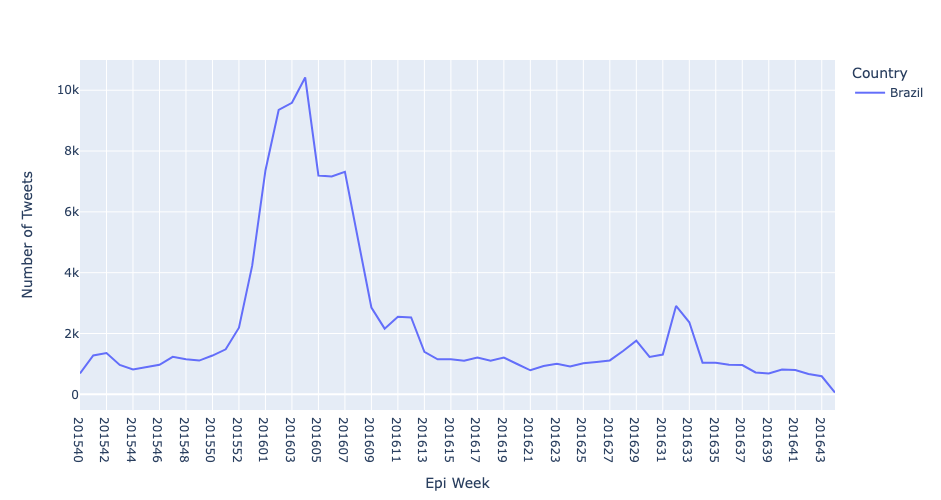

In [65]:
# Brazil over Epi Weeks - tweets

from itertools import product
import matplotlib.pyplot as plt

#top_20 = common_countries.reset_index().rename({"country":"counts",
#                                                "index":"country"},axis=1).loc[0:6,"country"].tolist()
#df.place_country.value_counts().rename_axis('unique_values').reset_index(name='counts')
#top_20 = top_20.loc[,0:20]
#top_20 = top_20.loc[0:20, "unique_values"].tolist()
#top_20

import plotly.express as px

loc_p = df[((df.place_country == "Brazil"))]
loc_p = loc_p.groupby(['place_country', "epi_week"])["id"].count().reset_index(name='counts')
loc_p = loc_p.sort_values(["epi_week"], ascending=True).reset_index(drop=True)

loc_temp = pd.DataFrame(list(product(loc_p.place_country.unique(), loc_p.epi_week.unique())), columns=['place_country', 'epi_week'])
loc_temp["counts"] = 0

loc_p = pd.concat([loc_p, loc_temp]).drop_duplicates(["place_country", "epi_week"])#, ignore_index=True)
loc_p = loc_p.sort_values(["epi_week"], ascending=True)

#only_loc_p = df_loc[df_loc.place_country.isin(top_20)]
#only_loc_p = only_loc_p.groupby(['place_country', "epi_week"])["id"].count().reset_index(name='counts')
# plot pie chart

fig = px.line(loc_p, x="epi_week", y="counts", color="place_country",
                 labels={
                     "epi_week": "Epi Week",
                     "counts": "Number of Tweets",
                     "place_country": "Country"},
             width=800,
             height=500)

fig.write_image("geotagged_tweets_brazil_epi_week.png")
fig.write_html("html/geotagged_tweets_brazil_epi_week.html")
fig.show()

In [60]:
cepi[(cepi.place_country.isin(top_20))]

,place_country,epi_week,counts
7,Brazil,201540,94
9,Spain,201540,57
20,Chile,201540,75
25,Uruguay,201540,51
26,United States,201540,157
...,...,...,...
6712,Argentina,201644,17297
6741,United States,201644,68
6743,Mexico,201644,21
6749,Brazil,201644,32


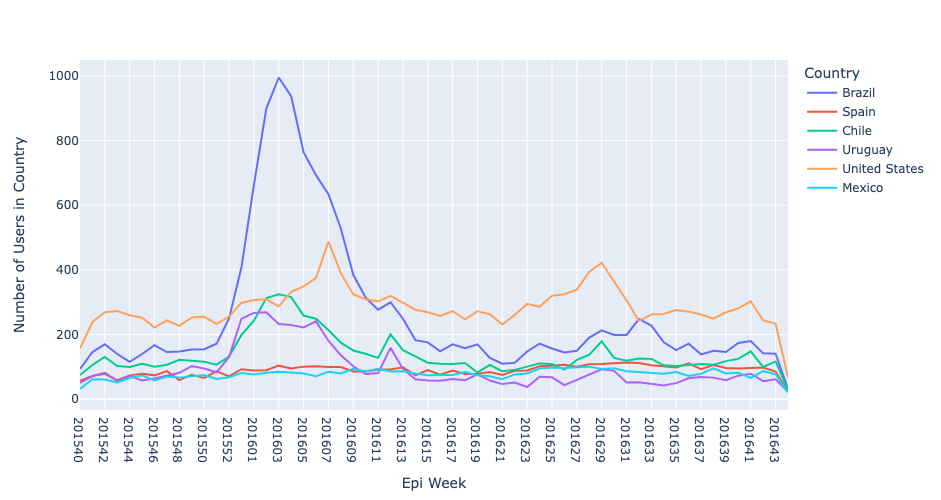

In [66]:
# Countries over Epi Weeks - users

import itertools

cepi = df.drop_duplicates(["username", "place_country", "epi_week"])
cepi = cepi.groupby(['place_country', "epi_week"])["username"].count().reset_index(name='counts')
cepi = cepi.sort_values(["epi_week"], ascending=True).reset_index(drop=True)

top_20 = common_countries.reset_index().rename({"country":"counts", "index":"country"},axis=1).loc[0:6,"country"].tolist()
#top_20 = cepi.place_country.value_counts().rename_axis('unique_values').reset_index(name='counts')
#top_20 = top_20.loc[0:20, "unique_values"].tolist()

import plotly.express as px

loc_p = cepi[(cepi.place_country.isin(top_20)) & (cepi.place_country != "Argentina")]
#loc_p = loc_p.groupby(['place_country', "epi_week"])["id"].count().reset_index(name='counts')
#loc_p = loc_p.sort_values(["epi_week"], ascending=True).reset_index(drop=True)

loc_temp = pd.DataFrame(list(product(loc_p.place_country.unique(), loc_p.epi_week.unique())), columns=['place_country', 'epi_week'])
loc_temp["counts"] = 0

loc_p = pd.concat([loc_p, loc_temp]).drop_duplicates(["place_country", "epi_week"])#, ignore_index=True)
loc_p = loc_p.sort_values(["epi_week"], ascending=True)


fig = px.line(loc_p, x="epi_week", y="counts", color="place_country",
                 labels={
                     "epi_week": "Epi Week",
                     "counts": "Number of Users in Country",
                     "place_country": "Country"},
             width=800,
             height=500)

fig.write_image("geotagged_users_country_epi_week.png")
fig.write_html("html/geotagged_users_country_epi_week.html")
fig.show()

In [ ]:
# lower value counts of Place Object?